In [69]:
import os
from os.path import join
import pandas as pd

from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

In [70]:
input_dir = join("..", "data", "_model_inputs")

os.listdir(input_dir)

['.DS_Store',
 'citibike_arrivals_monthly_by_neighborhood.csv',
 'citibike_departures_monthly_by_neighborhood.csv',
 'neighborhood_jobs.csv',
 'neighborhood_NTACode.csv',
 'neighborhood_number_of_citibike_stations.csv',
 'neighborhood_population.csv',
 'turnstile_monthly_by_neighborhood.csv']

In [71]:
def load_data_for_model():
    
    citibike_arrivals = pd.read_csv(join(input_dir, "citibike_arrivals_monthly_by_neighborhood.csv"), index_col=0)
    citibike_departures = pd.read_csv(join(input_dir, "citibike_departures_monthly_by_neighborhood.csv"), index_col=0)
    number_of_stations = pd.read_csv(join(input_dir, "neighborhood_number_of_citibike_stations.csv"), index_col=0)
    population = pd.read_csv(join(input_dir, "neighborhood_population.csv"), index_col=0)
    subway_volumes = pd.read_csv(join(input_dir, "turnstile_monthly_by_neighborhood.csv"), index_col=0)

    jobs = pd.read_csv(join(input_dir, "neighborhood_jobs.csv"), index_col=0)
    jobs['numJobs'] = jobs['BX_arrivals'] + jobs['BK_arrivals'] + jobs['MN_arrivals'] + jobs['QN_arrivals'] + jobs['SI_arrivals']
    jobs['NTACode'] = jobs.index
    
    citibike_arrivals['NTACode_yearMonth'] = citibike_arrivals['NTACode'] + "_" + citibike_arrivals['yearMonth'].astype(str)
    citibike_departures['NTACode_yearMonth'] = citibike_departures['NTACode'] + "_" + citibike_departures['yearMonth'].astype(str)
    subway_volumes['NTACode_yearMonth'] = subway_volumes['NTACode'] + "_" + subway_volumes['yearMonth'].astype(str)
    
    data = pd.merge(citibike_arrivals, citibike_departures[['NTACode_yearMonth', 'citibike_departures']], how="left", on="NTACode_yearMonth")
    data = pd.merge(data, number_of_stations, how='left', on='NTACode')
    data = pd.merge(data, population, how='left', on='NTACode')
    data = pd.merge(data, jobs[['NTACode', 'NTAName', 'numJobs']], how='left', on='NTACode')
    data = pd.merge(data, subway_volumes[['NTACode_yearMonth', 'subwayExits', 'subwayEntries']], how='left', on='NTACode_yearMonth')
    
    data['year'] = data['yearMonth'].apply(lambda x: str(x)[:4])
    data['month'] = data['yearMonth'].apply(lambda x: str(x)[-2:])
    
    # one hot encoding on month
    data = pd.concat([data, pd.get_dummies(data[['month']])], axis=1)
    
    # Fill NaN's with zero
    data.fillna(0, inplace=True)
    
    # Drop Jersey City
    data = data[data['NTACode'] != "JC"]
    
    return data

In [72]:
data = load_data_for_model()

# Try to predict monthly citibike departures by neighborhood

In [73]:
data.head()

,NTACode,yearMonth,citibike_arrivals,NTACode_yearMonth,citibike_departures,numStation,Population,NTAName,numJobs,subwayExits,subwayEntries,year,month,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,BK09,201601,3892,BK09_201601,4310.0,11.0,22887.0,Brooklyn Heights-Cobble Hill,11963.0,265914.0,310061.0,2016,01,1,0,0,0,0,0,0,0,0,0,0,0
1,BK09,201602,4498,BK09_201602,4963.0,11.0,22887.0,Brooklyn Heights-Cobble Hill,11963.0,268745.0,320431.0,2016,02,0,1,0,0,0,0,0,0,0,0,0,0
2,BK09,201603,7443,BK09_201603,7599.0,11.0,22887.0,Brooklyn Heights-Cobble Hill,11963.0,308964.0,359748.0,2016,03,0,0,1,0,0,0,0,0,0,0,0,0
3,BK09,201604,8779,BK09_201604,9172.0,11.0,22887.0,Brooklyn Heights-Cobble Hill,11963.0,292435.0,335191.0,2016,04,0,0,0,1,0,0,0,0,0,0,0,0
4,BK09,201605,11049,BK09_201605,11370.0,11.0,22887.0,Brooklyn Heights-Cobble Hill,11963.0,337177.0,362077.0,2016,05,0,0,0,0,1,0,0,0,0,0,0,0


Split data into training / testing based on year.

In [74]:
#data_train = data[data['year'] == '2016']
#data_test = data[data['year'] == '2017']

data_train = data.sample(frac=0.8,random_state=200)
data_test = data.drop(data_train.index)

In [75]:
feature_cols = ['Population', 'numJobs', 'subwayEntries', 'subwayExits', 'numStation', 
                'month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 
                'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12']

target_col = ["citibike_departures"]

#X = data[feature_cols]
#y = data[target_col]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = data_train[feature_cols]
X_test = data_test[feature_cols]
y_train = data_train[target_col]
y_test = data_test[target_col]

In [76]:
X_train.head()

,Population,numJobs,subwayEntries,subwayExits,numStation,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
41,54041.0,22754.0,1.349e+08,3.579e+05,2.0,0,0,1,0,0,0,0,0,0,0,0,0
526,43383.0,7936.0,3.986e+05,2.928e+05,12.0,0,0,0,0,0,0,0,0,1,0,0,0
1031,21049.0,1042.0,0.000e+00,0.000e+00,4.0,1,0,0,0,0,0,0,0,0,0,0,0
322,45774.0,22468.0,4.492e+05,2.527e+05,26.0,0,0,0,0,0,0,0,0,1,0,0,0
994,61207.0,46760.0,1.277e+06,1.102e+06,15.0,0,0,1,0,0,0,0,0,0,0,0,0


In [77]:
y_train.head()

,citibike_departures
41,123.0
526,2954.0
1031,14484.0
322,61876.0
994,11290.0


In [78]:
# Scale data to training set min max
scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

In [79]:
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)

y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

In [80]:
X_train.shape

(901, 17)

In [81]:
y_train.shape

(901, 1)

In [82]:
X_test.shape

(225, 17)

In [83]:
y_test.shape

(225, 1)

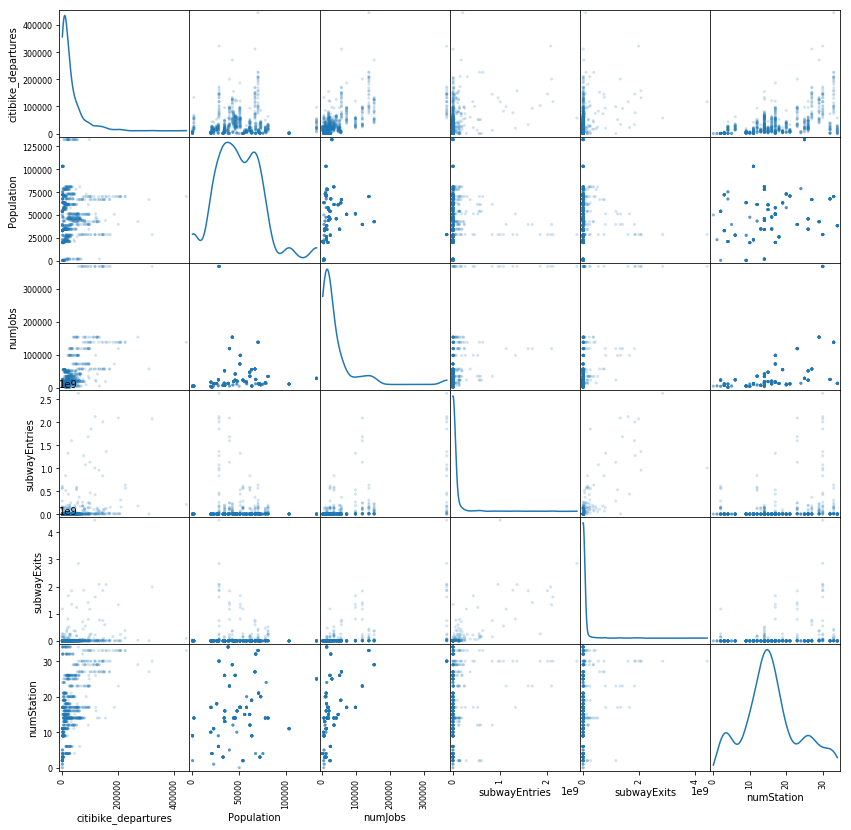

In [84]:
pd.plotting.scatter_matrix(data[['citibike_departures','Population', 'numJobs', 'subwayEntries', 'subwayExits', 'numStation']], 
                           alpha=0.2, figsize=(14, 14), diagonal='kde');

# Gradient Boosting Regressor

In [85]:
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 6,
          'learning_rate': 0.2, 'loss': 'ls'}

model = ensemble.GradientBoostingRegressor(**params)

model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)

# replace any negative predictions with zero
y_pred[y_pred < 0] = 0

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

r_squared = r2_score(y_test, y_pred)
print("R^2: %.4f" % r_squared)

MSE: 0.0013
R^2: 0.8686


In [86]:
results = pd.DataFrame()
results['actual'] = scaler_y.inverse_transform(y_test).ravel()
results['predicted'] = scaler_y.inverse_transform(y_pred.reshape(-1,1))
results['difference'] = results['actual'] - results['predicted']
results['difference_pct'] = results['difference'] / results['actual']
results['NTACode'] = data_test['NTACode'].values
results['NTAName'] = data_test['NTAName'].values
results['yearMonth'] = data_test['yearMonth'].values

In [87]:
import plotly.plotly as py

fig = {
    'data': [
  		{
  			'x': results.actual, 
        	'y': results.predicted, 
        	'text': results.NTAName, 
        	'mode': 'markers'
        }
    ],
    'layout': {
        'xaxis': {'title': 'Actual', 'type': 'linear'},
        'yaxis': {'title': "Prediction"}
    }
}

# IPython notebook
py.iplot(fig, filename='pandas/multiple-scatter')

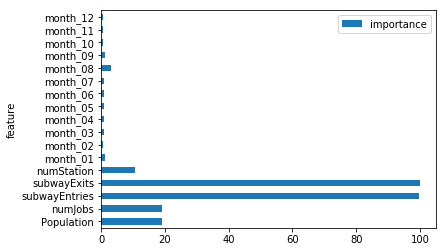

In [88]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = feature_cols
feature_importance_df['importance'] = feature_importance
feature_importance_df.index = feature_importance_df['feature']

feature_importance_df.plot(kind='barh')

# XGBoost

In [89]:
import xgboost

In [90]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.2, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=10)

In [91]:
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

# replace any negative predictions with zero
y_pred[y_pred < 0] = 0

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

r_squared = r2_score(y_test, y_pred)
print("R^2: %.4f" % r_squared)

MSE: 0.0009
R^2: 0.9043


In [92]:
results = pd.DataFrame()
results['actual'] = scaler_y.inverse_transform(y_test).ravel()
results['predicted'] = scaler_y.inverse_transform(y_pred.reshape(-1,1))
results['difference'] = results['actual'] - results['predicted']
results['difference_pct'] = results['difference'] / results['actual']
results['NTACode'] = data_test['NTACode'].values
results['NTAName'] = data_test['NTAName'].values
results['yearMonth'] = data_test['yearMonth'].values

In [93]:
import plotly.plotly as py

fig = {
    'data': [
  		{
  			'x': results.actual, 
        	'y': results.predicted, 
        	'text': results.NTAName, 
        	'mode': 'markers'
        }
    ],
    'layout': {
        'xaxis': {'title': 'Actual', 'type': 'linear'},
        'yaxis': {'title': "Prediction"}
    }
}

# IPython notebook
py.iplot(fig, filename='pandas/multiple-scatter')

# For every neighborhood without a citibike station, which one would have the highest ridership?

In [94]:
import geopandas as gpd

In [95]:
def load_neighborhoods():
    root =".."
    input_dir = join(root, "data", "neighborhood_tabulation_areas", "nyc_neighborhoods_population_bikestations")
    input_filename = "nyc_neighborhoods_population_bikestations.shp"
    neighborhoods = gpd.read_file(join(input_dir, input_filename))
    return neighborhoods

neighborhoods = load_neighborhoods()

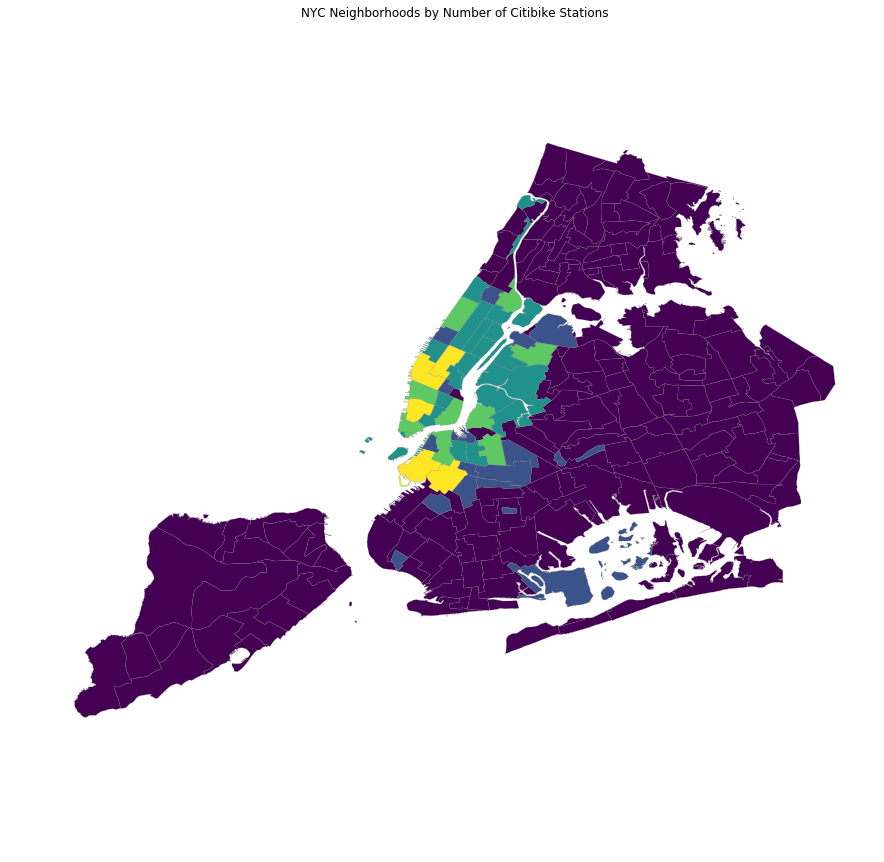

NYC Neighborhood Tabulation Areas (Equirectangular Projection)


In [96]:
f, ax = plt.subplots(1, figsize=(15,15))
neighborhoods.plot(ax=ax, linewidth=0.2, edgecolor='0.5', column='numStation', scheme="fisher_jenks")
ax.set_axis_off()
plt.axis('equal')
plt.title("NYC Neighborhoods by Number of Citibike Stations")
plt.show()
print("NYC Neighborhood Tabulation Areas (Equirectangular Projection)")

What's our prediction for NTACode BK88?

In [97]:
neighborhoods_with_no_stations = neighborhoods[neighborhoods['numStation'] == 0]['NTACode'].values

In [98]:
from tqdm import tqdm

In [99]:
predictions = []

for i in tqdm(neighborhoods_with_no_stations):
    
    annual_prediction = 0
    
    # generate 12 months of predictions
    for month in range(1, 12+1):

        # Population
        population = neighborhoods[neighborhoods['NTACode'] == i]['Population'].values[0]

        # Jobs
        jobs = pd.read_csv(join(input_dir, "neighborhood_jobs.csv"), index_col=0)
        jobs['numJobs'] = jobs['BX_arrivals'] + jobs['BK_arrivals'] + jobs['MN_arrivals'] + jobs['QN_arrivals'] + jobs['SI_arrivals']
        jobs['NTACode'] = jobs.index
        numJobs = jobs.loc[i]['numJobs']

        # Subway activity
        subway_volumes = pd.read_csv(join(input_dir, "turnstile_monthly_by_neighborhood.csv"), index_col=0)
        try:
            subway_exits = subway_volumes[(subway_volumes['NTACode'] == i) & (subway_volumes['yearMonth'] == month)]['subwayExits'].values[0]
            subway_entries = subway_volumes[(subway_volumes['NTACode'] == i) & (subway_volumes['yearMonth'] == month)]['subwayEntries'].values[0]
        except:
            subway_exits = 0
            subway_entries = 0

        # Number of hypothetical stations
        numStation = 10

        # Convert months to one hot
        mnth_index = int(month)-1
        months = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        months[mnth_index] = 1

        # scale these variables
        input_for_prediction = scaler_x.transform(np.array([[population, numJobs, subway_entries, subway_exits, numStation, *months]]))

        # make the prediction
        prediction = scaler_y.inverse_transform(xgb.predict(input_for_prediction).reshape(-1,1)).ravel()[0]
        
        annual_prediction += prediction

    predictions.append(annual_prediction)

100%|██████████| 145/145 [00:14<00:00,  9.67it/s]


In [100]:
outcome = pd.DataFrame()
outcome['NTACode'] = neighborhoods_with_no_stations
outcome['prediction'] = predictions

In [101]:
outcome.sort_values(by='prediction', ascending=False).head(20)

,NTACode,prediction
137,QN98,321580.595
135,BX99,255658.539
143,SI32,223220.094
100,SI25,222766.786
45,SI08,222766.786
0,BK88,222729.034
61,QN66,220484.126
54,SI99,217883.957
141,QN05,217571.724
84,SI48,217571.724
